## Data Loading ##

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
#Load the data
df = pd.read_csv('ACME-HappinessSurvey2020.csv')

#View the data: first 5 rows to check data loaded successfully
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


## Exploratory Data Analysis ##

In [27]:
#Get basic info of dataset
df.info()

#Basic statistics of the dataframe: mean, std, quartiles
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [28]:
# Basic check for null values in any of the columns in dataset
print(df.isnull().sum())



Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64


In [29]:
# Checking if the labels are balanced to prevent overfitting
# Count of Happy = 1 & Unhappy = 0 customers
print(df['Y'].value_counts())

1    69
0    57
Name: Y, dtype: int64


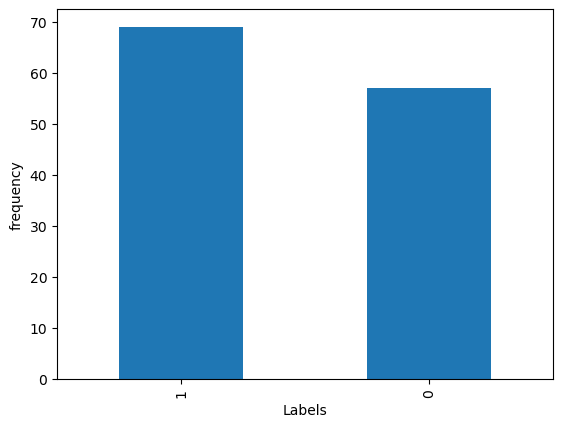

In [30]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

df['Y'].value_counts().plot(ax=ax, kind='bar', xlabel='Labels', ylabel='frequency')
plt.show()

In [72]:
# Calculate correlation coefficient for each feature (pair wise correlation between features)
df.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


Above you can see the correlation matrix. -ve values for correlation coefficient suggests that features are negatively correlated. 
For +ve values there is a positive correlation. If one feature increases the other also increases.

Lets Visualize this correlation matrix using a heat map

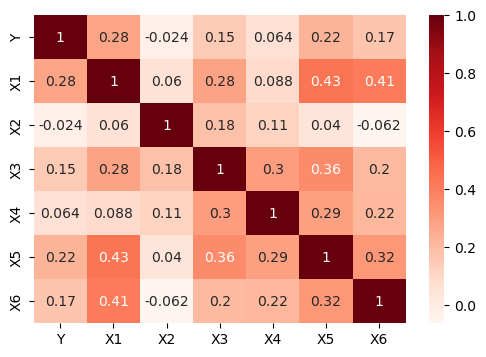

In [75]:
# Lets visualize:
plt.figure(figsize=(6,4))
correlations = df.corr()
sns.heatmap(correlations, annot=True, cmap=plt.cm.Reds) ## Ref: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
plt.show()

Some noticeable insights from data:
1. X2 - X6 have negative correlation
2. X2 - X1, X2 - X4, X5 - X2 : Have very low positive correlation 

In [ ]:
X = df.drop(columns="Y")   #Feature Matrix
y = df["Y"]                #Target Variables

### Feature Scaling ###

In [111]:
# Feature scaling using correlation coefficient between features and labels
cor_target = abs(correlations["Y"])
#Selecting highly correlated features using condition
relevant_features = cor_target[cor_target>0.16] ## Value to be experimented with.
relevant_features

Y     1.000000
X1    0.280160
X5    0.224522
X6    0.167669
Name: Y, dtype: float64

The condition above for getting relevant features that is > 0.1 shows that in general the features (questions) are not highly correlated with label Y i.e. customer happiness (Happy or Unhappy).
We will still use 0.1 for now to check model performance and later re-visit to experiment with more values.

### Oversampling using SMOTE ###
This technique improves the approach where examples in a minority class are duplicated to create balance. SMOTE synthesizes new examples as opposed to duplicating examples.

SMOTE selects examples that happen to be in proximity in a feature space. It then takes a new example at a point along the segment, joining adjacent examples. (Ref: https://www.section.io/engineering-education/imbalanced-data-in-ml/#:~:text=This%20imbalance%20can%20lead%20to,in%20a%20machine%20learning%20workflow. )

In [112]:
# We will use oversampling technique to balance labels
## Step 1: Create new dataframe with relevant features and numpy array for labels:
X = df.filter(['X1','X5','X6'], axis=1)
y = df.loc[:, 'Y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversample = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

X_train_res

,X1,X5,X6
0,5,5,5
1,5,5,5
2,5,4,5
3,4,4,5
4,3,3,4
...,...,...,...
111,5,4,5
112,3,2,3
113,3,4,3
114,5,5,5


In [113]:
# Now use the above dataset to train a logistic regression model
## Training
model = LogisticRegression()
model.fit(X_train_res, y_train_res.ravel())


LogisticRegression()

In [114]:
# Print results for the model with testing
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.54      0.64      0.58        11

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.61        26
weighted avg       0.63      0.62      0.62        26

